In [1]:
import torchvision.models as models
import torch
import torch.onnx

# load the pretrained model
resnet50 = models.resnet50(pretrained=True, progress=False).eval()

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
BATCH_SIZE=32

dummy_input=torch.randn(BATCH_SIZE, 3, 224, 224)

In [4]:
# export the model to ONNX
torch.onnx.export(resnet50, dummy_input, "resnet50_pytorch.onnx", verbose=False)

In [5]:
from skimage import io
import skimage
from skimage.transform import resize


In [6]:
print(skimage.__version__)
import PIL
PIL.__version__

0.19.2


'9.1.1'

In [7]:
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np


url='n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
img = np.expand_dims(np.array(img, dtype=np.float32), axis=0) # Expand image to have a batch dimension
input_batch = np.array(np.repeat(img, BATCH_SIZE, axis=0), dtype=np.float32) # Repeat across the batch dimension# Repeat across the batch dimension

input_batch.shape

(32, 224, 224, 3)

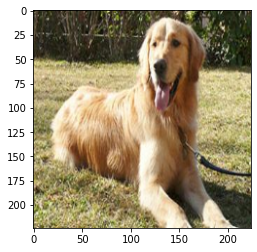

In [8]:
plt.imshow(input_batch[0].astype(np.float32))


In [9]:
resnet50_gpu = models.resnet50(pretrained=True, progress=False).to("cuda").eval()

In [10]:
input_batch_chw = torch.from_numpy(input_batch).transpose(1,3).transpose(2,3)
input_batch_gpu = input_batch_chw.to("cuda")

input_batch_gpu.shape

torch.Size([32, 3, 224, 224])

In [11]:
with torch.no_grad():
    predictions = np.array(resnet50_gpu(input_batch_gpu).cpu())

predictions.shape

(32, 1000)

In [12]:
%%timeit

with torch.no_grad():
    preds = np.array(resnet50_gpu(input_batch_gpu).cpu())

24.3 ms ± 3.75 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
resnet50_gpu_half = resnet50_gpu.half()
input_half = input_batch_gpu.half()

with torch.no_grad():
    preds = np.array(resnet50_gpu_half(input_half).cpu()) # Warm Up
    
preds.shape

(32, 1000)

In [14]:
%%timeit

with torch.no_grad():
    preds = np.array(resnet50_gpu_half(input_half).cpu())

12 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
indices = (-predictions[0]).argsort()[:5]
print("Class | Likelihood")
list(zip(indices, predictions[0][indices]))

Class | Likelihood


[(207, 13.21308),
 (208, 9.680686),
 (257, 9.4009695),
 (205, 8.847694),
 (256, 8.660016)]

In [ ]:
import os

os._exit(0) # Shut down all kernels so TRT doesn't fight with PyTorch for GPU memory

: 

: 

In [1]:
BATCH_SIZE = 32

In [17]:
import numpy as np

USE_FP16 = False
target_dtype = np.float16 if USE_FP16 else np.float32

In [18]:
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np

url='n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
input_batch = np.array(np.repeat(np.expand_dims(np.array(img, dtype=np.float32), axis=0), BATCH_SIZE, axis=0), dtype=np.float32)

input_batch.shape

(32, 224, 224, 3)

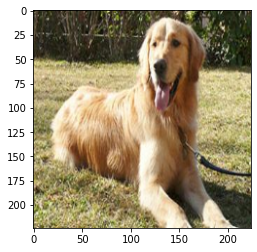

In [19]:
plt.imshow(input_batch[0].astype(np.float32))

In [43]:
import torch
from torchvision.transforms import Normalize

def preprocess_image(img):
    norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    result = norm(torch.from_numpy(img).transpose(0,2).transpose(1,2))
    return np.array(result, dtype=np.float16)

preprocessed_images = np.array([preprocess_image(image) for image in input_batch])

In [21]:
import tensorrt

In [22]:
!nvidia-smi 

Tue May 31 05:59:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.94       Driver Version: 470.94       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 30%   32C    P8    30W / 350W |   1383MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:82:00.0 Off |                  N/A |
| 30%   

In [23]:
# step out of Python for a moment to convert the ONNX model to a TRT engine using trtexec
if USE_FP16:
    !trtexec --onnx=resnet50_pytorch.onnx --saveEngine=resnet_engine_pytorch.trt  --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
else:
    !trtexec --onnx=resnet50_pytorch.onnx --saveEngine=resnet_engine_pytorch_32.trt  --explicitBatch

&&&& RUNNING TensorRT.trtexec [TensorRT v8204] # trtexec --onnx=resnet50_pytorch.onnx --saveEngine=resnet_engine_pytorch_32.trt --explicitBatch
[05/31/2022-05:59:40] [W] --explicitBatch flag has been deprecated and has no effect!
[05/31/2022-05:59:40] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[05/31/2022-05:59:40] [I] === Model Options ===
[05/31/2022-05:59:40] [I] Format: ONNX
[05/31/2022-05:59:40] [I] Model: resnet50_pytorch.onnx
[05/31/2022-05:59:40] [I] Output:
[05/31/2022-05:59:40] [I] === Build Options ===
[05/31/2022-05:59:40] [I] Max batch: explicit batch
[05/31/2022-05:59:40] [I] Workspace: 16 MiB
[05/31/2022-05:59:40] [I] minTiming: 1
[05/31/2022-05:59:40] [I] avgTiming: 8
[05/31/2022-05:59:40] [I] Precision: FP32
[05/31/2022-05:59:40] [I] Calibration: 
[05/31/2022-05:59:40] [I] Refit: Disabled
[05/31/2022-05:59:40] [I] Sparsity: Disabled
[05/31/2022-05:59:40] [I] Safe mode: Disabled
[05/

In [44]:
%%time

import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

f = open("resnet_engine_pytorch.trt", "rb")
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING)) 

engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

[05/31/2022-06:30:08] [TRT] [W] TensorRT was linked against cuBLAS/cuBLASLt 11.6.5 but loaded cuBLAS/cuBLASLt 11.5.2
[05/31/2022-06:30:08] [TRT] [W] TensorRT was linked against cuBLAS/cuBLASLt 11.6.5 but loaded cuBLAS/cuBLASLt 11.5.2
CPU times: user 9.63 ms, sys: 92.1 ms, total: 102 ms
Wall time: 98.8 ms


In [45]:
import numpy as np

# need to set input and output precisions to FP16 to fully enable it
output = np.empty([BATCH_SIZE, 1000], dtype = target_dtype) 

# allocate device memory
d_input = cuda.mem_alloc(1 * input_batch.nbytes)
d_output = cuda.mem_alloc(1 * output.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()

In [46]:
def predict(batch): # result gets copied into output
    # transfer input data to device
    cuda.memcpy_htod_async(d_input, batch, stream)
    # execute model
    context.execute_async_v2(bindings, stream.handle, None)
    # transfer predictions back
    cuda.memcpy_dtoh_async(output, d_output, stream)
    # syncronize threads
    stream.synchronize()
    
    return output

In [47]:
print("Warming up...")

pred = predict(preprocessed_images)

print("Done warming up!")

Warming up...
Done warming up!


In [48]:
%%timeit

pred = predict(preprocessed_images)

5.19 ms ± 9.63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
indices = (-pred[0]).argsort()[:5]
print("Class | Probability (out of 1)")
list(zip(indices, pred[0][indices]))

Class | Probability (out of 1)


[(603, 2953548.0),
 (103, 2953548.0),
 (109, 28066.484),
 (609, 28066.484),
 (87, 21534.662)]